# 0. 0 - IMPORTS


In [46]:
import datetime

import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import scipy.stats              as ss

from matplotlib                  import pyplot as plt
from matplotlib.gridspec         import GridSpec
from IPython.display             import Image
from tabulate                    import tabulate
from sklearn.model_selection     import train_test_split
from imblearn.over_sampling      import SMOTE
from boruta                      import BorutaPy
from sklearn.ensemble            import RandomForestRegressor
from sklearn.linear_model        import LogisticRegression
from sklearn.model_selection     import cross_val_score
from sklearn.metrics             import accuracy_score

%matplotlib inline

## 0.1 Helper Functions

In [47]:
def cat_att_distribution(df, attribute, response, title, rot=False):
    
    aux1 = df[[attribute, response]].groupby(attribute).count().reset_index()
    
    if attribute == 'Complain':
        plt.bar(x=aux1['Complain'], height=aux1[response], tick_label=["No", 'Yes'], width=0.2)
    elif attribute == 'has_children':
        plt.bar(x=aux1['has_children'], height=aux1[response], tick_label=["No", 'Yes'], width=0.2)
    else:
        plt.bar(x=aux1[attribute], height=aux1[response])
    
    plt.ylim([0, df.shape[0]])
    plt.axhline(y=333, linestyle='--', c='black');
    plt.title(title)
    if rot:
        plt.xticks(rotation=rot);
        

# Cramer's V
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values # contingency table
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(observed=cm)[0] # Chi-square test of independence of variables in a contingency table
    chi2_correction = max(0, chi2 - (k-1)*(r-1)/(n-1))
    k_correction = k - ((k-1)**2)/(n-1)
    r_correction = r - ((r-1)**2)/(n-1)
    
    return (np.sqrt((chi2_correction/n) / (min(k_correction-1, r_correction-1))))

## 0.2 Loading Data

In [48]:
df_raw = pd.read_csv('ifood-data-business-analyst-test/ml_project1_data.csv', thousands=',', index_col='ID')

# copy df
df1 = df_raw.copy()

df1

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,...,5,0,0,0,0,0,0,3,11,0
4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,...,7,0,0,0,1,0,0,3,11,0
7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,...,6,0,1,0,0,0,0,3,11,0


# 1.0 - DATA DESCRIPTION

## 1.1 Data Dimensions      

In [49]:
proportion = 100*(df1['Response'][df1['Response']!=0].count()/df1.shape[0])

print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

print('Proportion of positive response: {:,.2f}%'.format(proportion))

Number of rows: 2240
Number of columns: 28
Proportion of positive response: 14.91%


## 1.2 Data Types

In [50]:
df1['Dt_Customer'] = pd.to_datetime(df1['Dt_Customer'])

df1.dtypes

Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Z_CostContact                   int64
Z_Revenue   

## 1.3 Check NA

Looking for null values, one can see that the column `Income` has 24 empty values.

In [51]:
df1.isna().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Analyzing a bit deeper, it can be seen that most of these particular samples did not accepted the previous five offers nor responded well to the sixth. They also don't represent the profile of clients with high recency or high amounts of purchases. For that matter, **these empty values are going to be removed**.

Since the columns `Z_CostContact` and `Z_Revenue` just represent long arrays of unique values (3 for `Z_CostContact` and 11, for `Z_Revenue`), their variances equal zero and, therefore, they offer no value to the analysis and will be removed too.

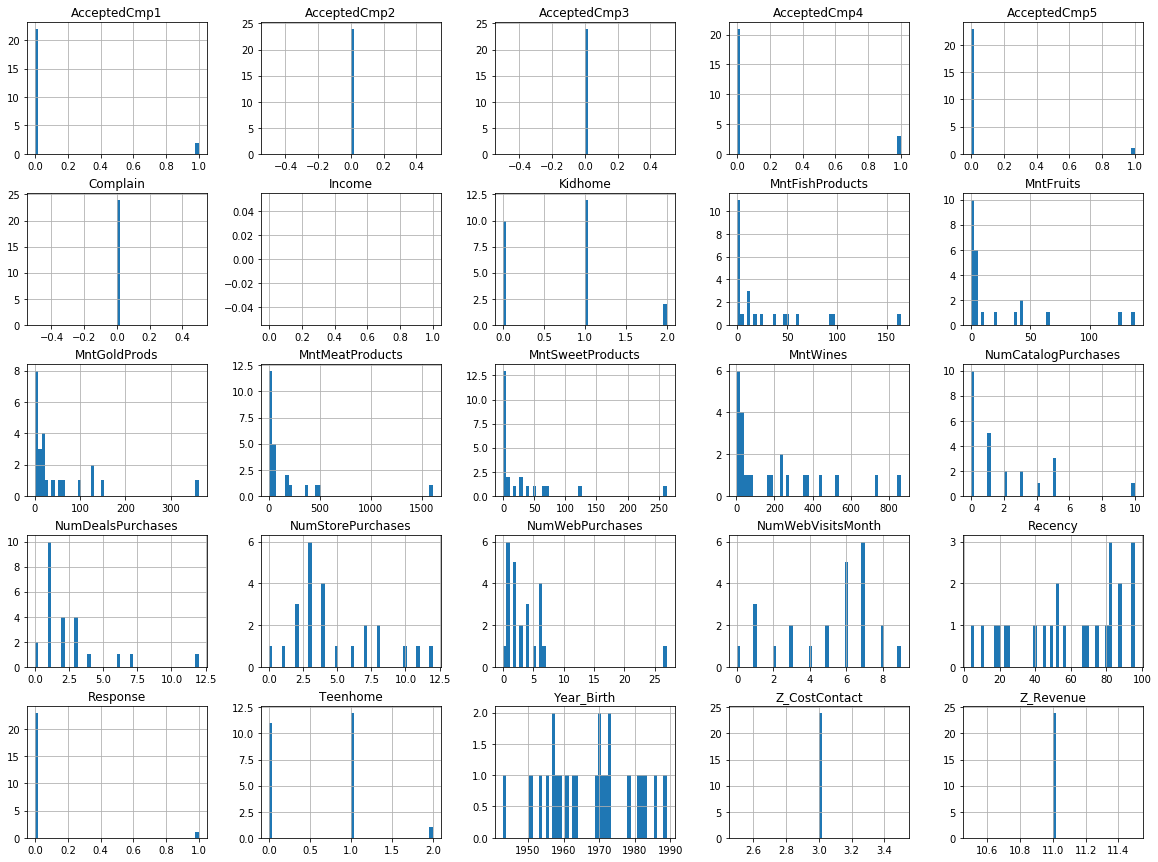

In [52]:
check_for_nan = df1[df1['Income'].isnull()]


check_for_nan.hist(bins=50, figsize = (20,15));

## 1.4 Dropping the empty values 

In [53]:
df1.dropna(axis = 0, how='any', inplace = True)

# Deleting Z_CostContact and Z_Revenue
print('Z_CostContact: {}\nZ_Revenue: {}'. format( str(df1['Z_CostContact'].unique()), str(df1['Z_Revenue'].unique() )))
del df1['Z_CostContact']
del df1['Z_Revenue']

df1.shape

Z_CostContact: [3]
Z_Revenue: [11]


(2216, 26)

## 1.5 Changing data types

In [54]:
cols_boolean = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain']
 
for i in cols_boolean:
    df1[cols_boolean] = df1[cols_boolean].apply(lambda x: x.astype(bool, copy=False), axis=1)

df1.dtypes

Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                     bool
AcceptedCmp4                     bool
AcceptedCmp5                     bool
AcceptedCmp1                     bool
AcceptedCmp2                     bool
Complain                         bool
Response                         bool
dtype: objec

## 1.6 Descriptive Statistics

In [55]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.6.1 Numerical Attributes

In [56]:
#Central tendencies - mean median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
dispersion1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
dispersion2 = pd.DataFrame(numerical_attributes.apply(min)).T
dispersion3 = pd.DataFrame(numerical_attributes.apply(max)).T
dispersion4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max()-x.min())).T
dispersion5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

#concatening
m = pd.concat([dispersion2,dispersion3,dispersion4, ct1, ct2, dispersion1, dispersion5, dispersion6]).T.reset_index()
m.columns = ['attribute', 'min','max', 'range','mean', 'median','std', 'skew','kurtosis']
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,Year_Birth,1893.0,1996.0,103.0,1968.820397,1970.0,11.982849,-0.353661,0.734670
1,Income,1730.0,666666.0,664936.0,52247.251354,51381.5,25167.396174,6.763487,159.636700
2,Kidhome,0.0,2.0,2.0,0.441787,0.0,0.536775,0.635610,-0.791164
3,Teenhome,0.0,2.0,2.0,0.505415,0.0,0.544058,0.407553,-0.989619
4,Recency,0.0,99.0,99.0,49.012635,49.0,28.941819,0.001648,-1.199777
5,MntWines,0.0,1493.0,1493.0,305.091606,174.5,337.251800,1.170720,0.582741
6,MntFruits,0.0,199.0,199.0,26.356047,8.0,39.784937,2.101658,4.054082
7,MntMeatProducts,0.0,1725.0,1725.0,166.995939,68.0,224.232662,2.025577,5.055477
8,MntFishProducts,0.0,259.0,259.0,37.637635,12.0,54.739727,1.916369,3.076476
9,MntSweetProducts,0.0,262.0,262.0,27.028881,8.0,41.062777,2.103328,4.106141


# 2.0 - FEATURE ENGINEERING

In [57]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map 

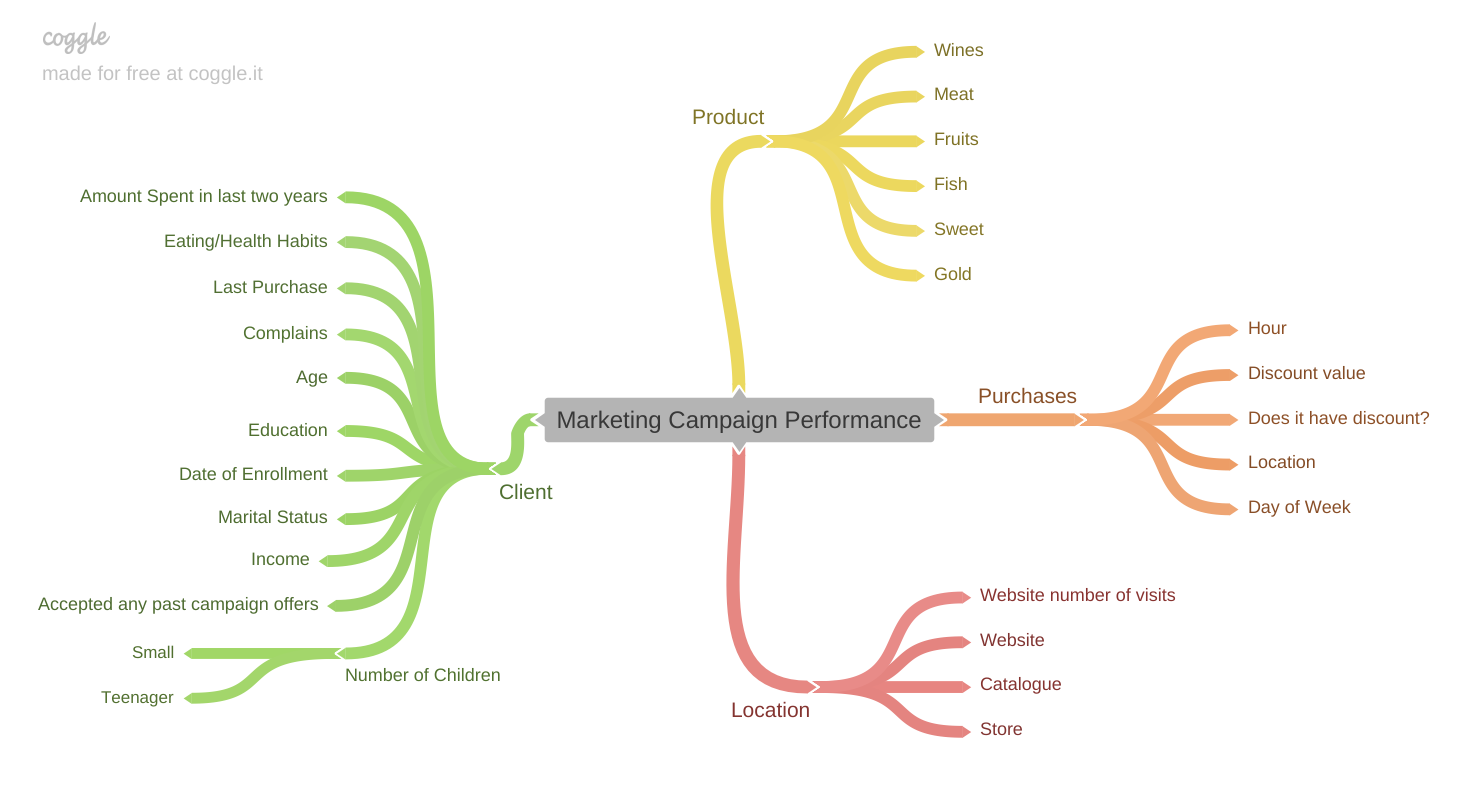

In [58]:
Image('img/Marketing_Campaign_Performance_mindmap.png')

## 2.2 Hypothesis Elaboration

### 2.2.1 Clients Hypothesis

**H1**: Couples are more prone to accept offers

**H2**: Clients with lower annual incomes accept more offers

**H3**: Clients who accept more offers are more likely to accept the next offer

**H4**: Clients with children accept more offers.

**H5**. Clients with less time since the last purchase accept more offers

**H6**: Clients with lower levels of education accept more offers

**H7**: New clients respond better to marketing offers

## 2.3 Feature Engineering

In [59]:
#age
df2['Age'] = df2.apply(lambda x: 2021 -x['Year_Birth'], axis=1)

# Amount of accepted offers
df2['num_offers_accepted'] = df2[['AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5',
                                  'AcceptedCmp1', 'AcceptedCmp2']].sum(axis=1)

# is_couple
df2['is_couple'] = df2.apply(lambda x: 1 if (x['Marital_Status'] == "Married") or (x['Marital_Status'] == "Together") else 0, axis=1)

df2['has_children'] = df2.apply(lambda x: 1 if (x['Teenhome'] > 0) or (x['Kidhome'] >0 ) else 0, axis=1)

df2['days_since_client'] = df2.apply(lambda x: pd.to_datetime('2021-08-20') - x['Dt_Customer'], axis=1)
df2['days_since_client'] = df2['days_since_client'].dt.days

##EXPENSES ANNUALLY

# year spend regular
df2['yr_spend'] = df2.apply(lambda x: 0.5 * (x['MntWines'] + x['MntFruits'] + x['MntMeatProducts'] + x['MntFishProducts'] + x['MntSweetProducts']), axis=1)

# yr_spend_ratio_regular
df2['yr_spend_ratio'] = df2.apply(lambda x: x['yr_spend']/x['Income'], axis=1)

# yr_spend_ratio_gold
df2['yr_spend_ratio_gold'] = df2.apply(lambda x: (0.5 * x['MntGoldProds']) / x['Income'], axis=1)

In [60]:
df2 = df2.drop(columns='Year_Birth', axis=1)

# 3.0 EXPLORATORY ANALYSIS

In [61]:
df3 = df2.copy()

## 3.1 Filtering Variables

In [62]:
numerical_cols = ['Age', 'days_since_client', 'Income','Kidhome', 'Teenhome', 'Recency','MntWines', 'MntFruits', 
                  'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                  'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                  'NumStorePurchases', 'NumWebVisitsMonth', 'num_offers_accepted','yr_spend','yr_spend_ratio', 'yr_spend_ratio_gold']

categorical_cols = ['Education', 'Marital_Status','AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5',
                    'AcceptedCmp1', 'AcceptedCmp2','Complain', 'Response', 'is_couple','has_children']

categorical_attributes=df3[categorical_cols]
numerical_attributes = df3[numerical_cols]

## 3.2 Univariate Analysis

### 3.2.1 Numerical

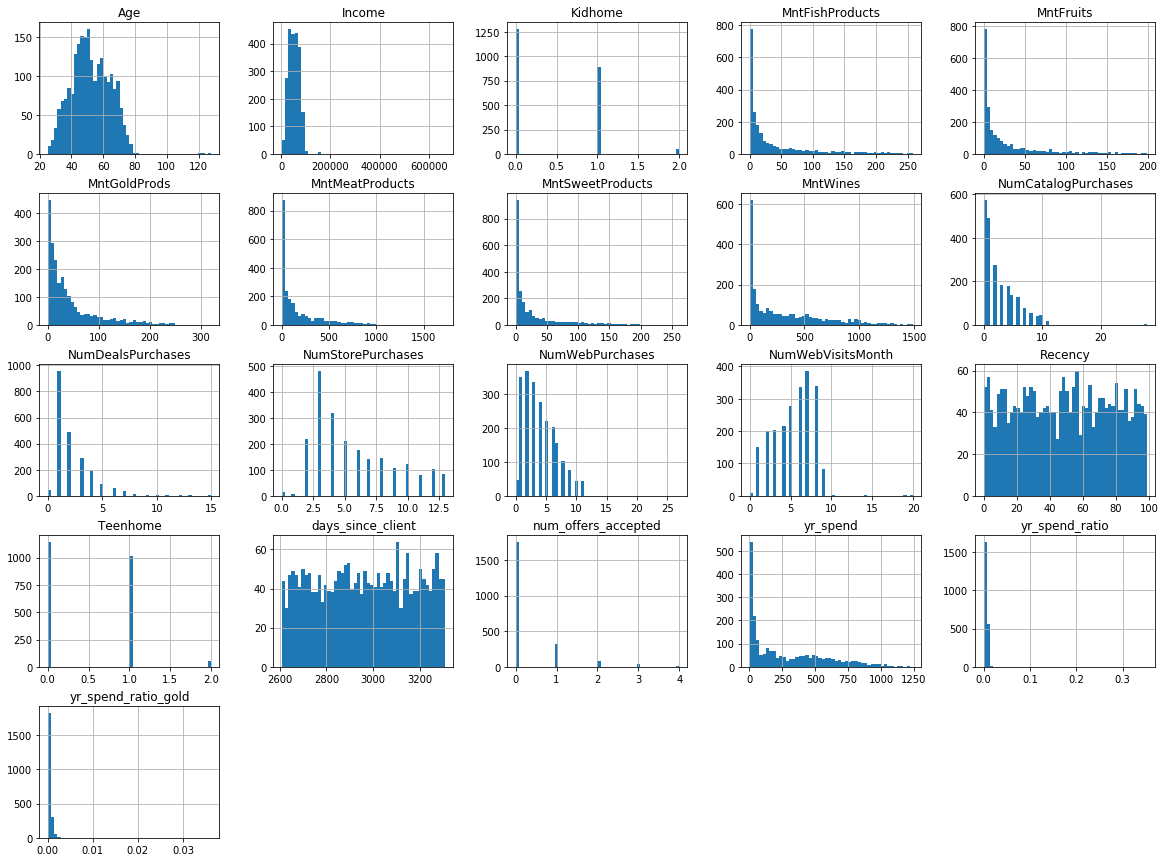

In [63]:
numerical_attributes.hist(bins=50, figsize = (20,15));


### 3.2.2 Categorical

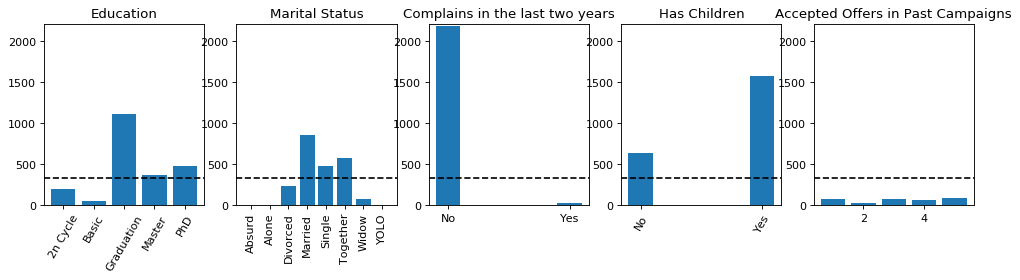

In [64]:
fig=plt.figure(figsize=(15,3), dpi= 80)

grid = GridSpec(1,5)

#Education
plt.subplot(grid[0,0])
cat_att_distribution(categorical_attributes, 'Education','Response', 'Education', rot=60)

#Education
plt.subplot(grid[0,1])
cat_att_distribution(categorical_attributes, 'Marital_Status','Response', 'Marital Status', rot=90)

#Complain
plt.subplot(grid[0,2])
cat_att_distribution(categorical_attributes, 'Complain','Response', 'Complains in the last two years')

#Accepted Campaigns
cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
accepted_campaigns = {}

i = 1
for elem in cols:    
    aux = categorical_attributes[[elem, 'Response']].groupby(elem).sum().reset_index()
    accepted_campaigns[i] = aux.iloc[1,1]
    i+=1
    

plt.subplot(grid[0,3])
cat_att_distribution(categorical_attributes, 'has_children','Response', 'Has Children', rot=60)
    
accepted_campaigns = pd.DataFrame(accepted_campaigns.items())
accepted_campaigns.columns = ['Campaign_Number', 'Accepted']

plt.subplot(grid[0,4])
plt.bar(accepted_campaigns['Campaign_Number'],accepted_campaigns['Accepted'])
plt.ylim([0, 2216])
plt.axhline(y=333, linestyle='--', c='black')
plt.title('Accepted Offers in Past Campaigns');

Here we can see that columns from `AcceptedCmp1` to `AcceptedCmp5` and `Complain` offer little value to the desired response. These columns will be dropped.

In [65]:
df3[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'Complain']].astype(int).sum()

AcceptedCmp1    142
AcceptedCmp2     30
AcceptedCmp3    163
AcceptedCmp4    164
AcceptedCmp5    162
Complain         21
dtype: int64

In [66]:
cols_to_drop = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'Complain']
df3 = df3.drop(cols_to_drop, axis=1)

## 3.3 Bivariate Analysis

#### H1: Couples accept more offers

First, let's see how couples and non-couples behave in past offers:

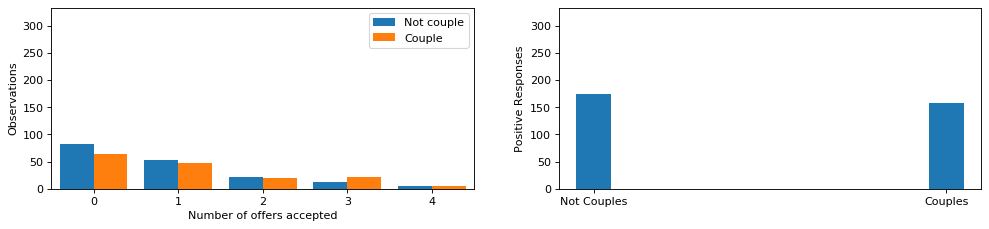

In [67]:
fig=plt.figure(figsize=(15,3), dpi= 80)


# Plot 2
plt.subplot(1,2,1)
aux1=df3[['Response','num_offers_accepted','is_couple']].groupby(['num_offers_accepted', 'is_couple']).sum().reset_index()
x = np.arange(5)
y1 = aux1.loc[aux1['is_couple']==0, 'Response']
y2 = aux1.loc[aux1['is_couple']==1, 'Response']
width = 0.40
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.axis([-.5 ,4.5, 0,333])
plt.xlabel('Number of offers accepted')
plt.ylabel('Observations')
plt.legend(['Not couple','Couple']);

# Plot 1
plt.subplot(1,2,2)
aux1 = df3[['Response','is_couple']].groupby('is_couple').sum().reset_index()
x = np.arange(2)
y = aux1['Response']
##plot data in grouped manner of bar type
plt.bar(x, y, width = 0.1)
plt.xticks(ticks =[0,1], labels=['Not Couples', 'Couples'])
plt.ylabel('Positive Responses')
plt.axis([-.1,1.1 , 0,333]);

**False**

In [68]:
ratio = (df3[df3['is_couple']==1].shape[0])/df3.shape[0]

print('Couples \'Married\' and \'Living together\' represent {:.2f}% of the observations,'.format(ratio*100))
print('but only 158 out of 1430 couples ({:.2f}%) accepted the 6th pilot offer.'.format(100*158/1430))

Couples 'Married' and 'Living together' represent 64.53% of the observations,
but only 158 out of 1430 couples (11.05%) accepted the 6th pilot offer.


Also, there is not a clear behavior according to past offers

#### H2: Clients with lower annual incomes accept more offers





As shown on the boxplot and distplot below, we have a long range of unequal annual incomes among the observations. For the sake of visualization, we are going to filter the outliers (annual incomes greater than 140,000) out.

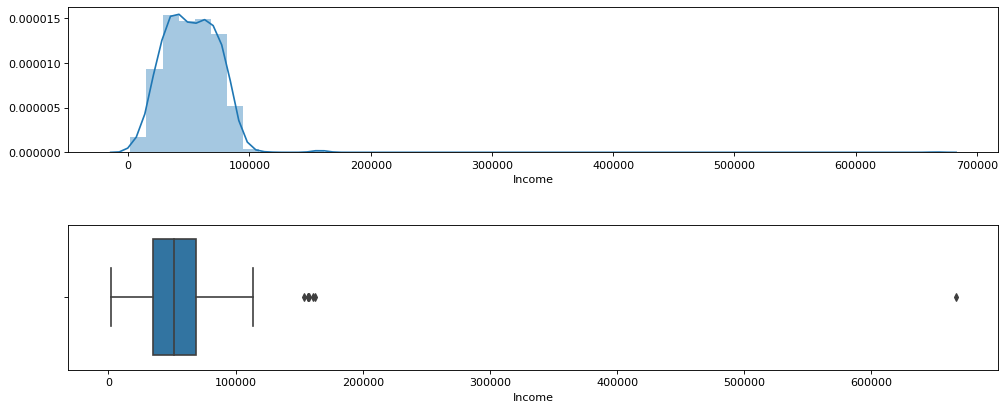

In [69]:
fig=plt.figure(figsize=(15,6), dpi= 80)

aux1=df3[df3['Income']<140_000]

grid = GridSpec(2,2, hspace=0.5)
# Plot1
plt.subplot(grid[0,:])
sns.distplot(df3['Income']);

#Plot 2
plt.subplot(grid[1,:])
sns.boxplot(df3['Income']);

#### Detecting outliers

##### Age and Income

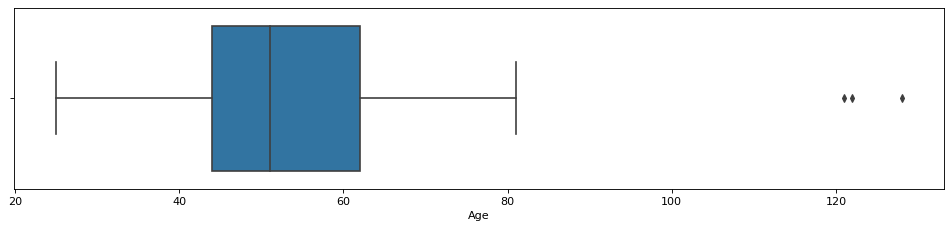

In [70]:
fig=plt.figure(figsize=(15,3), dpi= 80)

sns.boxplot(df3['Age']);

These outliers are going to be removed

In [71]:
df3 = df3[(df3['Age']< 80) & (df3['Income'] < 140_000)]


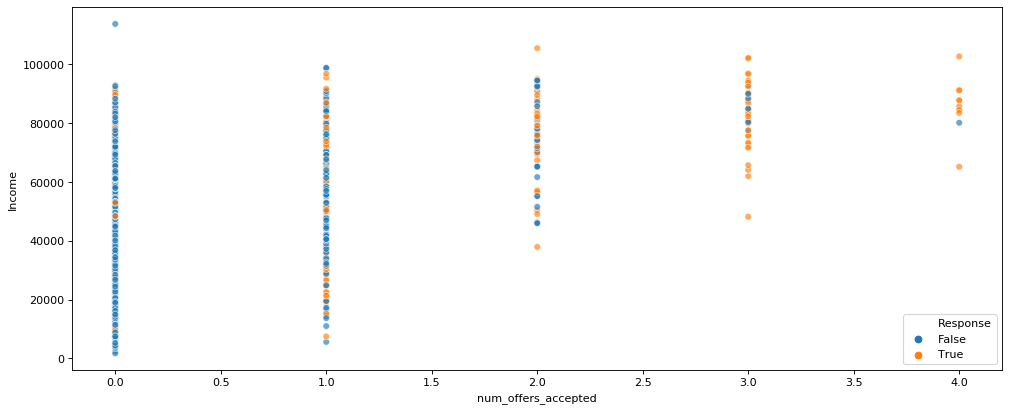

In [72]:
fig=plt.figure(figsize=(15,6), dpi= 80)

aux1=df3[df3['Income']<140_000]
sns.scatterplot(data=aux1, y='Income', x='num_offers_accepted', hue='Response', alpha=0.65);

**False**.

There is a visual pattern that shows that the clients with lower annual budgets are prone to accept less promo offers. 

It can be seen either that the higher the number of offers accepted (axis x), better the response to the pilot test to the sixth promotion (there is a greater proportion of orange dots in higher offers accepted positions)

#### H3: Clients who accept more offers are more likely to accept the next offer

**True**.

#### H4: Clients with children accept more offers.

**False**. Seeing from the table below, we realize that the number of kids and teenagers are inversely proportional number of accepted offers

In [73]:
aux1 = df3[['Kidhome', 'Teenhome', 'Response']].groupby(['Teenhome', 'Kidhome']).sum().reset_index()

aux1['children_proportion'] = aux1['Response']/333
aux1.sort_values(by='children_proportion', ascending=False)

,Teenhome,Kidhome,Response,children_proportion
0,0,0,168.0,0.504505
1,0,1,66.0,0.198198
3,1,0,50.0,0.150150
4,1,1,42.0,0.126126
6,2,0,3.0,0.009009
2,0,2,2.0,0.006006
7,2,1,2.0,0.006006
5,1,2,0.0,0.000000


The scatterplot also emphasizes that. The radius represents the frequency inside the desired `Response`

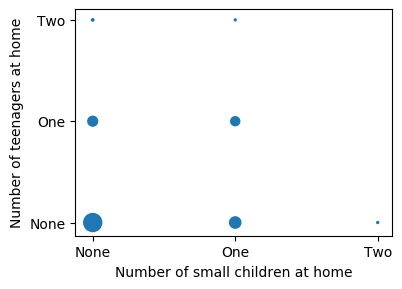

In [74]:
fig=plt.figure(figsize=(9,3), dpi= 100)

grid = GridSpec(1,2)

plt.subplot(grid[0,0])
plt.scatter(x=aux1['Kidhome'], y=aux1['Teenhome'], s=(aux1['Response']))
plt.xticks(ticks=[0,1,2], labels=['None', 'One', 'Two'])
plt.yticks(ticks=[0,1,2], labels=['None', 'One', 'Two'])
plt.xlabel('Number of small children at home')
plt.ylabel('Number of teenagers at home');

#### H5. Clients with less time since the last purchase accept more offers


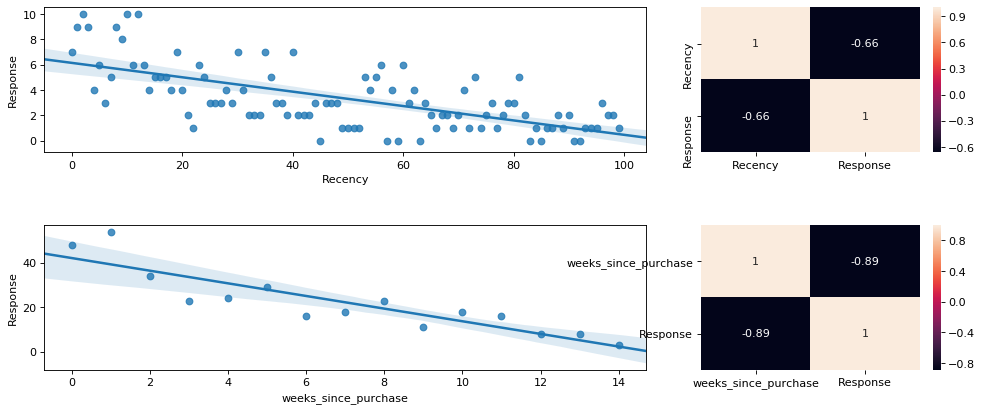

In [75]:
fig=plt.figure(figsize=(15,6), dpi= 80)

#grid = GridSpec(2,3)
grid = GridSpec(2,3, hspace=0.5)

# regplot 1
plt.subplot(grid[0,0:2])
aux1 = df3[['Recency','Response']].groupby('Recency').sum().sort_values('Recency').reset_index()
sns.regplot(x = 'Recency', y = 'Response', data = aux1);

# heatmap 1
plt.subplot(grid[0,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# regplot 2
plt.subplot(grid[1,0:2])
aux1['weeks_since_purchase'] = (aux1['Recency']/7).astype(int)

aux2= aux1[['weeks_since_purchase','Response']].groupby('weeks_since_purchase').sum().sort_values('weeks_since_purchase').reset_index()
sns.regplot(x = 'weeks_since_purchase', y = 'Response', data = aux2);


# heatmap 2
plt.subplot(grid[1,2])
sns.heatmap(aux2.corr(method='pearson'), annot=True);

**True**. Although a natural oscillation can be seen for days straight, the regression curve can predict with a significant better fit each 14 days. It it clear that clients with less days since the last purchase are more prone to take the offer.

#### H6: Clients with lower levels of education accept more offers

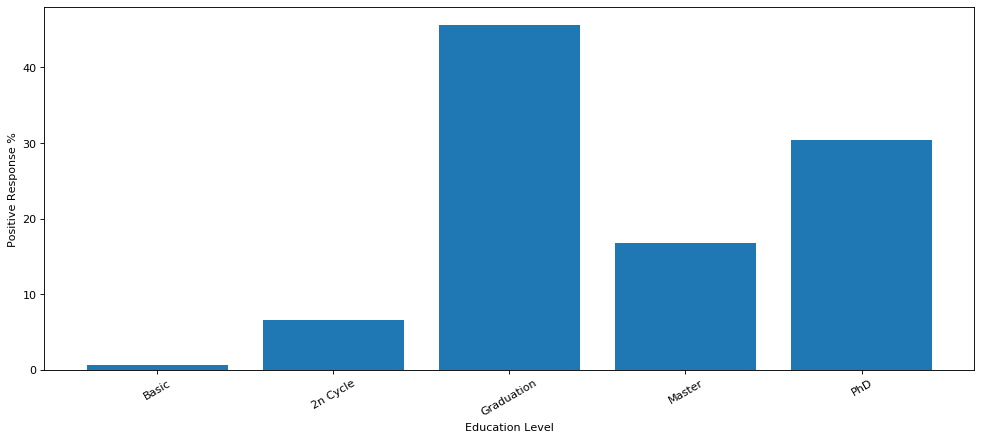

In [76]:
fig=plt.figure(figsize=(15,6), dpi= 80)

aux1 = df3[['Education', 'Response']].groupby('Education').sum().reset_index()
aux1 = aux1.iloc[[1,0,2,3,4]]
aux1['proportion_accepted']= aux1['Response']*100/333
x = aux1['Education']
y = aux1['proportion_accepted']
plt.bar(x,y)
plt.ylabel('Positive Response %')
plt.xlabel('Education Level')
plt.xticks(rotation=30)
plt.show();

**False**. Clients with Graduation levels are more likely to take promo offers

#### H7

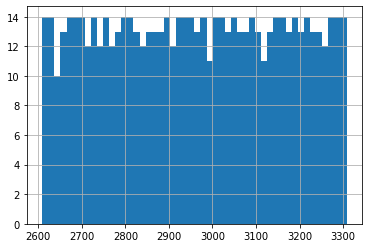

In [77]:
aux1 = df3[['days_since_client', 'Response']].groupby('days_since_client').sum().reset_index().sort_values('Response')
aux1['days_since_client'].hist(bins=50);

**False**. Its histogram shows that, between the available dates, there is no clear distinction one the variable `days_since_client` and the number of `Response`

### Summary

In [78]:
tab =[['Hypothesis','Conclusion','Relevance'],
      ['H1','False','High'],
      ['H2','False','Medium'],
      ['H3','True','High'],
      ['H4','False','High'],
      ['H5','True','Medium'],
      ['H6','False','High'],
      ['H7', 'False', 'Low']]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         High
H2            False         Medium
H3            True          High
H4            False         High
H5            True          Medium
H6            False         High
H7            False         Low


## 3.3 Multivariate Analysis

### 3.3.1 Numerical

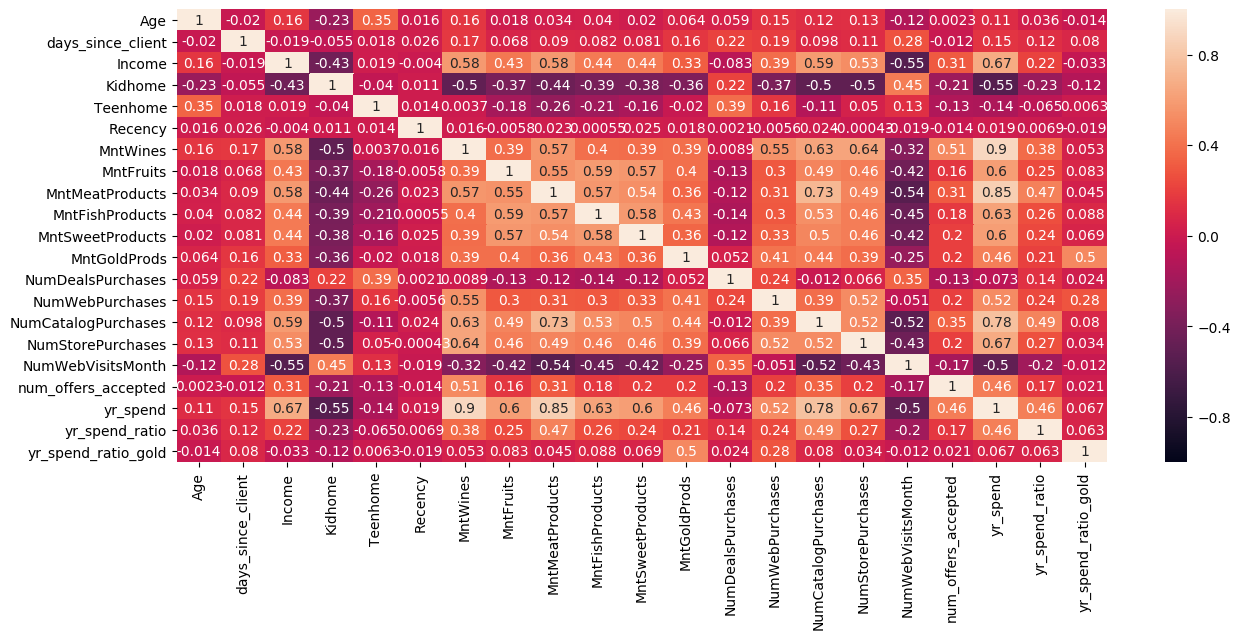

In [79]:
fig=plt.figure(figsize=(15,6), dpi= 100)

correlation = numerical_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True, vmin=-1, vmax=1);

### 3.3.2 Categorical

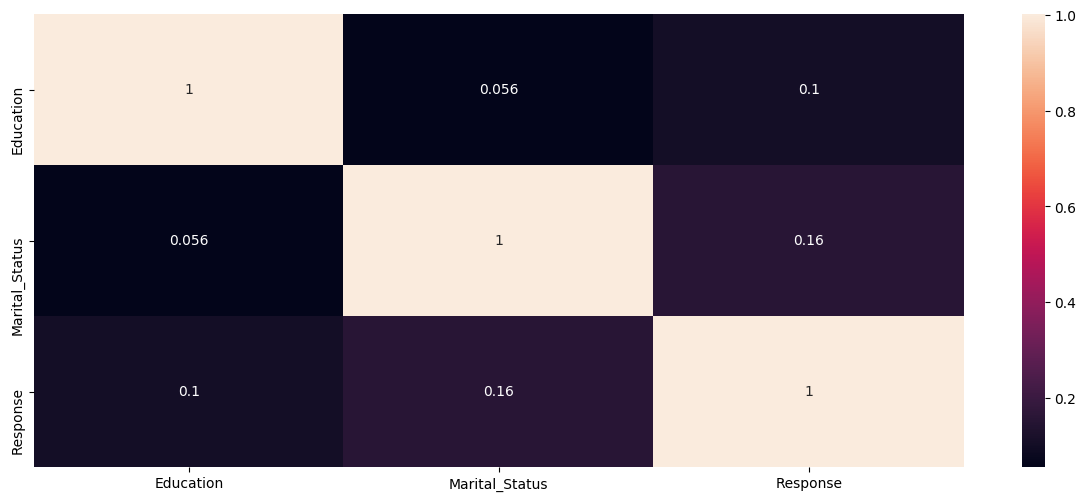

In [80]:
categorical_cols = ['Education', 'Marital_Status','Response']
a = df3[categorical_cols]

# Calculate Cramer's V
a1 = cramer_v(x = a['Education'], y = a['Education'])
a2 = cramer_v(x = a['Education'], y = a['Marital_Status'])
a3 = cramer_v(x = a['Education'], y = a['Response'])

a4 = cramer_v(x = a['Marital_Status'], y = a['Education'])
a5 = cramer_v(x = a['Marital_Status'], y = a['Marital_Status'])
a6 = cramer_v(x = a['Marital_Status'], y = a['Response'])

a7 = cramer_v(x = a['Response'], y = a['Education'])
a8 = cramer_v(x = a['Response'], y = a['Marital_Status'])
a9 = cramer_v(x = a['Response'], y = a['Response'])


# Final Dataset
d = pd.DataFrame({'Education':[a1, a2, a3],
                  'Marital_Status': [a4, a5, a6],   
                  'Response':[a7, a8, a9]})
d = d.set_index(d.columns)

fig=plt.figure(figsize=(15,6), dpi= 100)
sns.heatmap(d, annot=True);

# 4.0 DATA PREPARATION

In [81]:
df4 = df3.copy()

## 4.1 Rescaling data


In [82]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


In [83]:
for col in ['has_children', 'is_couple', 'Dt_Customer', 'days_since_client']:
    del df4[col]

In [84]:
rs = RobustScaler()
mms = MinMaxScaler()

# columns with present outliers
with_outliers = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 
                 'NumWebVisitsMonth', 'num_offers_accepted', 'yr_spend', 'yr_spend_ratio', 'yr_spend_ratio_gold']

for col in with_outliers:
    df4[col] = rs.fit_transform(df4[[col]].values)
    
# columns without outliers
no_outliers = ['Income', 'Kidhome', 'Teenhome', 'Recency','NumStorePurchases',
               'Age', 'num_offers_accepted'] 

for col in no_outliers:
    df4[col] = mms.fit_transform(df4[[col]].values)
    

## 4.2 Encoding

In [85]:
df4 = pd.get_dummies(df4, columns=['Education', 'Marital_Status'])

# 5.0 FEATURES SELECTION

In [87]:
df5 = df4.copy()

## 5.1 Data Balancing

In [99]:
sm = SMOTE(sampling_strategy=0.7,random_state=68)

X_oversampled, y_oversampled = sm.fit_resample(X_train, y_train)

In [100]:
X_oversampled['Response'].value_counts()

False    1300
True      909
Name: Response, dtype: int64

## 5.2 Split data into train and test

In [101]:
X_train, X_test = train_test_split(df5, test_size=0.3, random_state=42, shuffle=True)

y_train = X_train['Response']
y_test  = X_test['Response']

## 5.3 Boruta as Features Selector

In [102]:
## Boruta training and testing sets
#X_oversampled_n = X_oversampled.drop('Response', axis=1).values
#y_oversampled_n = y_oversampled.values.ravel()
#
##Random Forest Regressor
#rf = RandomForestRegressor(n_jobs=-1)
#
#boruta_selection = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=73).fit(X_oversampled_n, y_oversampled_n)

In [103]:
#cols_selected = boruta_selection.support_.tolist()
#
### Best features selected by Boruta (X_train_fs)
#X_train_fs = X_oversampled.drop(["Response"], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()
#
## Cols excluded by boruta
#cols_not_selected = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
#
#print('Columns selected: {}\n\n\nColumns not selected: {}'.format(cols_selected_boruta, cols_not_selected))

In [104]:
#BorutaPy finished running.
#
#Iteration: 	100 / 100
#Confirmed: 	17
#Tentative: 	1
#Rejected: 	15
#    
#Columns selected: ['Income', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 
#                   'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
#                   'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
#                   'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'num_offers_accepted',
#                   'yr_spend', 'yr_spend_ratio_gold']
#
#
##Columns not selected: ['Education_2n Cycle', 'Education_Basic', 'Education_Graduation', 
##                       'Education_Master', 'Education_PhD', 'Kidhome', 'Marital_Status_Absurd', 
##                       'Marital_Status_Alone', 'Marital_Status_Divorced', 'Marital_Status_Married', 
##                       'Marital_Status_Single', 'Marital_Status_Together', 'Marital_Status_Widow', 
##                       'Marital_Status_YOLO', 'MntGoldProds', 'yr_spend_ratio']
#

### 5.3.1 Manual Boruta Selection

In order to rapidly perform the analysis without the need to rerun the Boruta algorithm everytime, we will copy manually the columns selected by it.

In [105]:
cols_selected_boruta = ['Income', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 
                        'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
                        'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
                        'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 
                        'num_offers_accepted', 'yr_spend', 'yr_spend_ratio_gold']


X_train_fs = X_oversampled[cols_selected_boruta]
X_test_fs = X_test[cols_selected_boruta]

## 5.4 Machine Learning Classifier models

### 5.4.1 Logistic Regression

In [106]:
clf = LogisticRegression(tol=0.01, random_state=40, verbose=1)

clf.fit(X_train_fs, y_oversampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(random_state=40, tol=0.01, verbose=1)

In [107]:
y_pred = clf.predict(X_test_fs)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8396369137670197


In [123]:
clf_cv= cross_val_score(clf, X_train_fs, y_oversampled, cv=5, n_jobs=-1, scoring='accuracy')
clf_cv.mean()

0.8211900144673254